In [1]:
from torch.nn.functional import normalize
from GraphAwareNestedCVEvaluationThreads import GraphAwareNestedCVEvaluation
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops
from hyperopt import hp
import numpy as np
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
import shap
import torch
from NestedCV import index_to_mask

/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
cora_dataset = Planetoid(root='data/', name='Cora', split="public")
cora_dataset.transform = T.NormalizeFeatures()
cora_dataset[0].edge_index = add_self_loops(cora_dataset[0].edge_index)[0]

citeseer_dataset = Planetoid(root='data/', name='CiteSeer', split="public")
citeseer_dataset.transform = T.NormalizeFeatures()
citeseer_dataset[0].edge_index = add_self_loops(citeseer_dataset[0].edge_index)[0]

pubmed_dataset = Planetoid(root='data/', name='PubMed', split="public")
pubmed_dataset.transform = T.NormalizeFeatures()
pubmed_dataset[0].edge_index = add_self_loops(pubmed_dataset[0].edge_index)[0]

In [3]:
cora_dataset[0].x.to(torch.float16)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float16)

In [4]:
cora_dataset.num_classes

7

In [5]:
def norm_user_function(kwargs):
    return  normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2.0, dim = 1)
    
def user_function(kwargs):
    return  kwargs["original_features"] + kwargs["summed_neighbors"]
    
class ModelSpace():
    def __init__(self):
        self.space = None
        self.weight_decay_limits = (1e-6, 1e-2)
        self.lr_limits = (1e-4, 1e-1)
        self.initialize_space()

    def initialize_space(self):
        framework_choices = {
            'hops': [[0,2], [0,3], [1, 3], [1,4], [2,4], [2, 5], [3,5],[3,6], [0, 3, 6], [0, 3, 8]],
            'attention_config': [None,{'inter_layer_normalize': False,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None}, 
                     {'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None},
                     {'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.001,
                     'dropout_attn': None}],
            'user_function': [norm_user_function, user_function],
        }
         
        self.space = {
            **{key: hp.choice(key, value) for key, value in framework_choices.items()},
            'lr': hp.loguniform('lr',np.log(self.lr_limits[0]), np.log(self.lr_limits[1])),
            'weight_decay': hp.loguniform('weight_decay',np.log(self.weight_decay_limits[0]), np.log(self.weight_decay_limits[1])),
        }
        
    def add_choice(self, key, items):
        self.space[key] = hp.choice(key, items)
        
    def add_uniform(self, key, limits: tuple):
        self.space[key] = hp.uniform(key, limits[0], limits[1])
        
    def add_loguniform(self, key, limits: tuple):
        self.space[key] = hp.loguniform(key, np.log(limits[0]), np.log(limits[1]))
        
    def add_qloguniform(self, key, limits, q):
        self.space[key] = hp.qloguniform(key, low=np.log(limits[0]), high=np.log(limits[1]), q=q)

class LogitsticRegressionSpace(ModelSpace):
    def __init__(self,dataset):
        super().__init__()
        self.dataset = dataset

    def get_space(self):
        self.add_choice('in_dim', [self.dataset.num_features])
        self.add_choice('out_dim', [self.dataset.num_classes])
        self.add_qloguniform('max_iter', [50, 500], 10) #300
        return self.space  

In [6]:
import torch
import copy

class TorchLogRegression(torch.nn.Module):
    def __init__(self, in_dim, out_dim, max_iter, lr, weight_decay, device = torch.device("cuda:2")):
        super().__init__()
        self.lin = torch.nn.Linear(in_dim, out_dim)
        torch.nn.init.xavier_uniform_(self.lin.weight)
        self.epochs = int(max_iter)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.lr = lr
        self.weight_decay = weight_decay
        self.coef_ = None
        self.intercept_ = None
        self.device = device
        self = self.to(device)

    def forward(self, x):
        x = self.lin(x)
        return x #torch.nn.functional.softmax(x, dim = 1)

    def finalize(self):
        self.coef_ = self.state_dict()['lin.weight'].cpu().numpy()
        self.intercept_ = self.state_dict()['lin.bias'].cpu().numpy()

    def input_validation(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        x = x.to(self.device)
        return x

    def fit(self, X, y):
        X = self.input_validation(X)
        y = self.input_validation(y)
        
        optim = torch.optim.Adam(params=self.parameters(), lr = self.lr, weight_decay= self.weight_decay)
        loss_fun = torch.nn.CrossEntropyLoss()

        for epoch in range(self.epochs):
            self.train()
            out = self(X)
            loss = loss_fun(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
        self.finalize()
        return self

    def predict_proba(self, X):
        if not torch.is_tensor(X):
            X = torch.from_numpy(X)
        X = X.to(self.device)
        with torch.inference_mode():
            self.eval()
            return torch.nn.functional.softmax(self(X), dim = 1).cpu().numpy()

    def get_params(self, *args, **kwargs):
        return {
            "max_iter": self.epochs,
            "lr": self.lr,
            "in_dim": self.in_dim,
            "out_dim": self.out_dim,
            "weight_decay": self.weight_decay,
        }
    def __sklearn_clone__(self):
        return copy.deepcopy(self)

In [7]:
store = dict({})

In [8]:
for i, dataset in enumerate([citeseer_dataset, pubmed_dataset, cora_dataset]):
    data = dataset[0]
    lr_space = LogitsticRegressionSpace(dataset)
    graph_aware_nestedCV_evaluation = GraphAwareNestedCVEvaluation(2, TorchLogRegression, data, max_evals= 600, classifier_on_device  = True, parallelism=5, threads= 3) # 2 instead of None
    graph_aware_nestedCV_evaluation.nested_cross_validate(3, 3, lr_space.get_space())
    store[dataset.name] = graph_aware_nestedCV_evaluation.nested_transd_cv

0it [00:00, ?it/s]

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/12 10:51:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
trial task 0 failed, exception is An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job 0 cancelled as part of cancellation of all jobs
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:2719)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$doCancelAllJobs$2(DAGS

KeyboardInterrupt: 

/home/dwalke/git/graph_aware_ml/EnsembleFrameworkThreads.py:366: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:231.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")
/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [9]:
store["Cora"].train_times

[1.2334232330322266, 0.12903857231140137, 1.127110481262207]

In [10]:
for item in store:
    print(f"""
    {item}:\n
    {store[item]}
    """)


    CiteSeer:

    
        Using a 3 x 3 nested StratifiedKFold Cross-Validation, we obtain:
        0.7683 +- 0.0140.

        self.outer_scores: [0.77006312 0.75022543 0.78449053]

        self.best_params_per_fold: [{'attention_config': {'cosine_eps': 0.01, 'dropout_attn': None, 'inter_layer_normalize': False, 'use_pseudo_attention': True}, 'hops': (1, 4), 'in_dim': 3703, 'lr': 0.01939383246238456, 'max_iter': 400.0, 'out_dim': 6, 'user_function': <function norm_user_function at 0x7f7b991d69e0>, 'weight_decay': 0.0004045479225065218}, {'attention_config': {'cosine_eps': 0.01, 'dropout_attn': None, 'inter_layer_normalize': False, 'use_pseudo_attention': True}, 'hops': (1, 4), 'in_dim': 3703, 'lr': 0.024398357448941428, 'max_iter': 460.0, 'out_dim': 6, 'user_function': <function norm_user_function at 0x7f7b991d69e0>, 'weight_decay': 0.0004948901557715407}, {'attention_config': {'cosine_eps': 0.01, 'dropout_attn': None, 'inter_layer_normalize': False, 'use_pseudo_attention': True}, '

# for dataset in store:
    graph_aware_nestedCV_evaluation = store[dataset]
    print(f"Required training time for {dataset}: {np.array(graph_aware_nestedCV_evaluation.train_times).mean():.1f} s.")

Required training time for CiteSeer: 0.9 s.
Required training time for PubMed: 1.6 s.
Required training time for Cora: 1.0 s.

In [12]:
store["Cora"]


        Using a 3 x 3 nested StratifiedKFold Cross-Validation, we obtain:
        0.8844 +- 0.0044.

        self.outer_scores: [0.87818383 0.88815061 0.88691796]

        self.best_params_per_fold: [{'attention_config': None, 'hops': (0, 3, 8), 'in_dim': 1433, 'lr': 0.06808805142142106, 'max_iter': 380.0, 'out_dim': 7, 'user_function': <function norm_user_function at 0x7f7b991d69e0>, 'weight_decay': 8.914535491304986e-05}, {'attention_config': None, 'hops': (2, 4), 'in_dim': 1433, 'lr': 0.040277133342435795, 'max_iter': 50.0, 'out_dim': 7, 'user_function': <function norm_user_function at 0x7f7b991d69e0>, 'weight_decay': 5.343130378846667e-05}, {'attention_config': None, 'hops': (0, 3, 8), 'in_dim': 1433, 'lr': 0.04112175078673906, 'max_iter': 350.0, 'out_dim': 7, 'user_function': <function norm_user_function at 0x7f7b991d69e0>, 'weight_decay': 9.383978466258302e-05}]

        self.best_models: [<EnsembleFrameworkThreads.Framework object at 0x7f7cfb683fa0>, <EnsembleFrameworkThreads.F

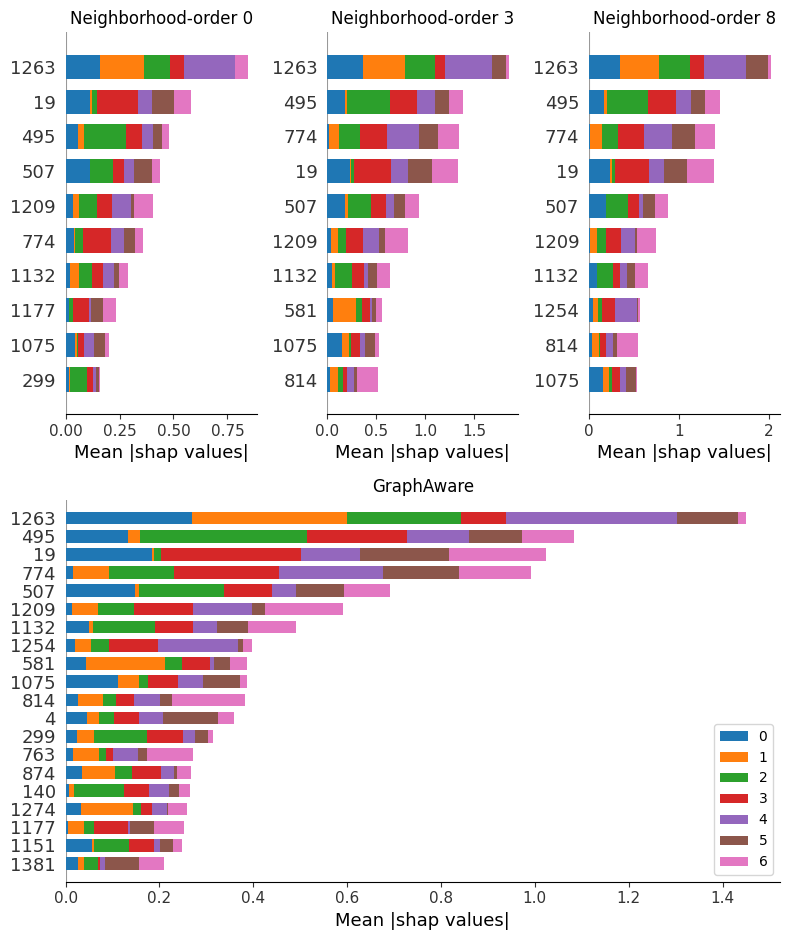

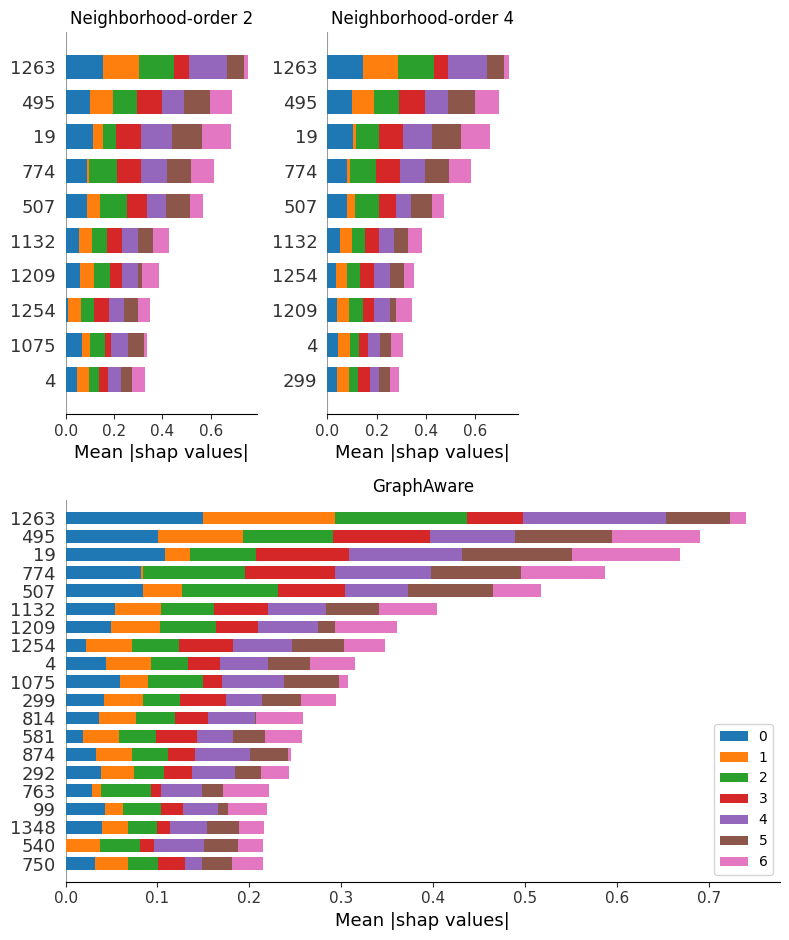

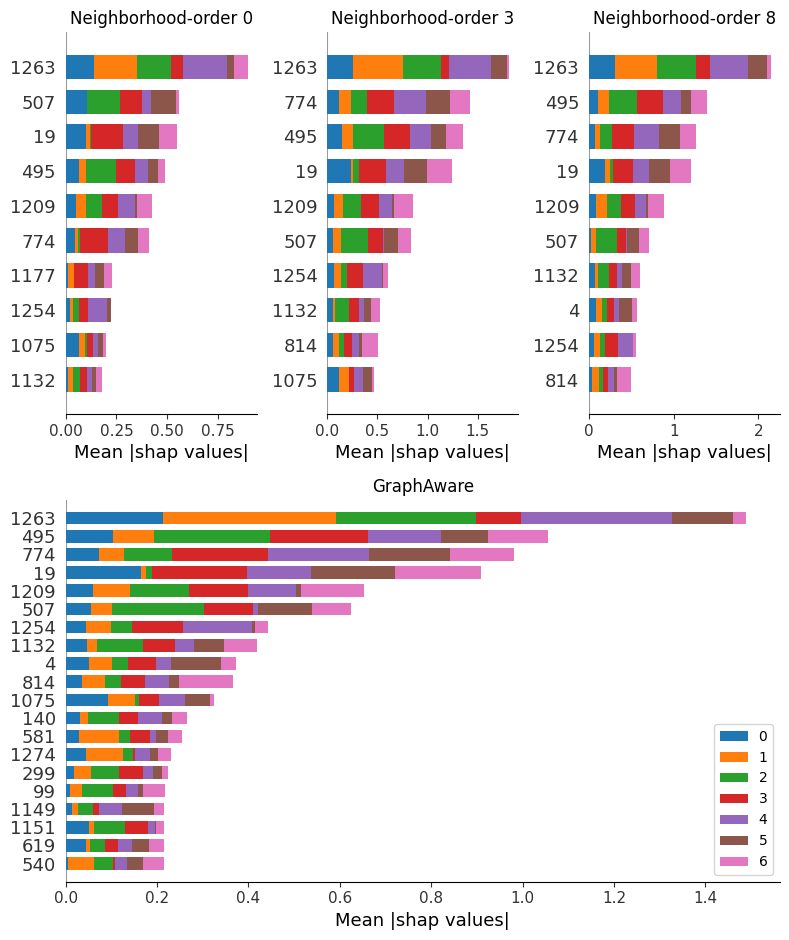

In [13]:
import matplotlib.pyplot as plt

class_colors = {
     0: '#1f77b4',  # Blue
    1: '#ff7f0e',  # Orange
    2: '#2ca02c',  # Green
    3: '#d62728',  # Red
    4: '#9467bd',  # Purple
    5: '#8c564b',  # Brown
    6: '#e377c2'   # Pink
}

for split_index, (train_index, test_index) in enumerate(store["Cora"].kf_outer.split(data.x, data.y)):
    train_mask = index_to_mask(data.x.shape[0], train_index)
    test_mask = index_to_mask(data.x.shape[0], test_index)
    background_datasets = store["Cora"].best_models[split_index].get_features(data.x, data.edge_index, train_mask, is_training=True)
    test_data = store["Cora"].best_models[split_index].get_features(data.x, data.edge_index, test_mask, is_training=False)
    shap_store = []
    fig =  plt.figure(figsize=(30, 15))
    gs = fig.add_gridspec(2, 3)
    
    for background_data_index, background_data in enumerate(background_datasets):
        explainer = shap.LinearExplainer(store["Cora"].best_models[split_index].trained_clfs[background_data_index], background_data.cpu().numpy())
        data_to_explain = test_data[background_data_index].cpu().numpy()
        shap_values_ex = explainer.shap_values(data_to_explain) #[0]
        shap_store.append(shap_values_ex)
        
        feature_names = [j for j in range(data_to_explain.shape[-1])]
        class_names = [i for i in range(7)]
        hop = store["Cora"].best_models[split_index].hops_list[background_data_index]

        ax = fig.add_subplot(gs[0, background_data_index])
        plt.sca(ax)
        shap.summary_plot(shap_values_ex, class_names= class_names, feature_names = feature_names, plot_type="bar", show=False, max_display=10, color = lambda i: class_colors[i],
                         class_inds='original')
        ax.set_xlabel("Mean |shap values|")
        ax.set_title(f"Neighborhood-order {hop}")
        ax.get_legend().remove()
        
    shap_values_avg = np.array(shap_store).mean(0)
    shap_values_avg = [shap_values_avg[i, :, :] for i in range(shap_values_avg.shape[0])]
    ax = fig.add_subplot(gs[1, :])
    plt.sca(ax)
    shap.summary_plot(shap_values_avg, plot_type="bar", class_names= class_names, feature_names = feature_names, max_display=20, color = lambda i: class_colors[i],
                         class_inds='original', show = False)
    ax.set_xlabel("Mean |shap values|")
    ax.set_title(f"GraphAware")
    ax.legend(fontsize=10, loc='lower right')
    plt.tight_layout()
    plt.show()